# Classification of breast cancer tumors

This notebook represents a typical starting point for many python projects. We have received a dataset from somewhere, and we want to explore it, and build a useful classifier that be utilized by clinicians.

The dataset used here is the UCI ML Breast Cancer Wisconsin (Diagnostic) dataset. We have removed some of the features but it is a "toy" dataset, and high classification accuracy is trivial. Real data pipelines are often much more complicated.

In [1]:
import pandas as pd

First import and look at the data.

In [2]:
training_data = pd.read_csv('data/breast_cancer_train.csv')
testing_data = pd.read_csv('data/breast_cancer_test.csv')

target_to_diagnosis = {0: 'malignant', 1: 'benign'}
diagnosis_to_target = {v: k for k, v in target_to_diagnosis.items()}

training_data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,target
0,14.69,13.98,98.22,656.1,0.10310,0.18360,0.14500,0.06300,0.2086,0.07406,1
1,13.17,18.66,85.98,534.6,0.11580,0.12310,0.12260,0.07340,0.2128,0.06777,0
2,12.95,16.02,83.14,513.7,0.10050,0.07943,0.06155,0.03370,0.1730,0.06470,1
3,18.31,18.58,118.60,1041.0,0.08588,0.08468,0.08169,0.05814,0.1621,0.05425,0
4,15.13,29.81,96.71,719.5,0.08320,0.04605,0.04686,0.02739,0.1852,0.05294,0


In [3]:
# count unique values in the target column
training_data['target'].value_counts()

target
1    288
0    167
Name: count, dtype: int64

The data is quite imbalanced, but it isn't particularly important. We perform a train-validation split and get the feature names. This might be useful if you want to look at feature importances.

In [4]:
# train validation split
from sklearn.model_selection import train_test_split
X = training_data.drop('target', axis=1)
y = training_data['target']

feature_names = X.columns

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
feature_names

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension'],
      dtype='object')

Plot a PCA, because why not? This can be a good way to see if anything weird is going on with your data, or if it will amenable to clustering algorithms.

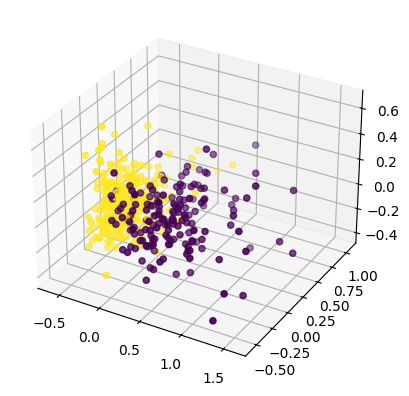

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

X_scaled = MinMaxScaler().fit_transform(X)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y)
plt.show()

We try an initial basic classifier to see what we get.

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=3)),
    ('model', LogisticRegression())
])

pipeline.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
y_train_pred = pipeline.predict(X_train)
y_val_pred = pipeline.predict(X_val)

train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

print(f'Train accuracy: {train_acc:.2f}')
print(f'Test accuracy: {val_acc:.2f}')

Train accuracy: 0.94
Test accuracy: 0.87


That's already pretty good, but we can quickly tune the hyperparameters to find the best number of principle components and regularization score.

In [9]:
# hyperparameter tuning
from sklearn.model_selection import GridSearchCV
import warnings
import numpy as np

warnings.filterwarnings('ignore')

param_grid = {
    'model__C': np.logspace(-3, 1, 100),
    'pca__n_components': np.arange(1, 31)
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=3)),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model__C': array([1.00000000e-03, 1.09749877e-03, 1.20450354e-03, 1.32194115e-03,
       1.45082878e-03, 1.59228279e-03, 1.74752840e-03, 1.91791026e-03,
       2.10490414e-03, 2.31012970e-03, 2.53536449e-03, 2.78255940e-...
       2.47707636e+00, 2.71858824e+00, 2.98364724e+00, 3.27454916e+00,
       3.59381366e+00, 3.94420606e+00, 4.32876128e+00, 4.75081016e+00,
       5.21400829e+00, 5.72236766e+00, 6.28029144e+00, 6.89261210e+00,
       7.56463328e+00, 8.30217568e+00, 9.11162756e+00, 1.00000000e+01]),
                         'pca__n_components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])},
             scoring='accuracy')

In [10]:
print(f'Best hyperparameters: {grid_search.best_params_}')
print(f'Best accuracy: {grid_search.best_score_:.2f}')

# validation set
y_val_pred = grid_search.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
print(f'Validation accuracy: {val_acc:.2f}')

Best hyperparameters: {'model__C': 0.4641588833612782, 'pca__n_components': 8}
Best accuracy: 0.96
Validation accuracy: 0.87


A little better. Now retrain the entire model on the train and validation set.

In [11]:
# train best model on the full training set
best_model = grid_search.best_estimator_
best_model.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=8)),
                ('model', LogisticRegression(C=0.4641588833612782))])

We save the best model for later.

In [47]:
import joblib
joblib.dump(best_model, 'breast_cancer_model.pkl')

['breast_cancer_model.pkl']

Now we load the full test set and see how we go...

In [13]:
# full test set prediction
X_test = testing_data.drop('target', axis=1)
y_test = testing_data['target']

y_test_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print(f'Test accuracy: {test_acc:.2f}')

Test accuracy: 0.94


It would also be nice to get probabilities for the diagnoses.

In [14]:
# get probabilities
y_test_prob = best_model.predict_proba(X_test)

In [19]:
y_test_pred

array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1])

In [ ]:
confidence = np.zeros(len(y_test))
for i, pred in enumerate(y_test_pred):
    confidence[i] = y_test_prob[i, pred]

In [18]:
y_test_prob.round(3)

array([[1.   , 0.   ],
       [0.694, 0.306],
       [0.4  , 0.6  ],
       [0.993, 0.007],
       [0.038, 0.962],
       [0.94 , 0.06 ],
       [0.999, 0.001],
       [0.945, 0.055],
       [1.   , 0.   ],
       [0.757, 0.243],
       [0.02 , 0.98 ],
       [0.442, 0.558],
       [0.005, 0.995],
       [0.944, 0.056],
       [0.799, 0.201],
       [0.   , 1.   ],
       [0.997, 0.003],
       [0.01 , 0.99 ],
       [0.857, 0.143],
       [0.311, 0.689],
       [0.993, 0.007],
       [1.   , 0.   ],
       [0.775, 0.225],
       [0.998, 0.002],
       [0.023, 0.977],
       [0.299, 0.701],
       [1.   , 0.   ],
       [0.011, 0.989],
       [0.696, 0.304],
       [0.012, 0.988],
       [0.   , 1.   ],
       [0.011, 0.989],
       [0.003, 0.997],
       [0.012, 0.988],
       [0.   , 1.   ],
       [0.005, 0.995],
       [0.002, 0.998],
       [0.944, 0.056],
       [0.887, 0.113],
       [0.076, 0.924],
       [0.99 , 0.01 ],
       [0.021, 0.979],
       [1.   , 0.   ],
       [0.2

In [54]:
X_test = testing_data.drop('target', axis=1)
y_test = testing_data['target']

# single sample prediction
random_index = np.random.choice(X_test.shape[0], )
sample = X_test.iloc[random_index]

model = joblib.load('breast_cancer_model.pkl')

sample_pred = model.predict([sample])

print(f'Predicted diagnosis: {target_to_diagnosis[sample_pred[0]]}')
print(f'Actual diagnosis: {target_to_diagnosis[y_test.iloc[random_index]]}')

Predicted diagnosis: malignant
Actual diagnosis: malignant


The goal now is to write a piece of software that will allow a user to input the measurements of the tumor and returns a prediction.